# Cold War Simulation

In *Predicting Politics*, BDM applies the model to forecasting the course of the Cold War, starting from 1948. Here, I will try to replicate this experiment.

In [1]:
import copy
from collections import defaultdict, namedtuple, Counter
from itertools import combinations


import numpy as np
import scipy.stats

import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from negotiation_model import *
from bdm_agent import *

from bdm_replication import *


# Data serialization

In [23]:
class Model_Output:
    def __init__(self, model):
        '''
        Store data from model run.
        '''
        self.agent_vars = model.datacollector.get_agent_vars_dataframe()
        self.model_vars = model.datacollector.get_model_vars_dataframe()
        self.log = model.log

# Using Original Data

In [3]:
book_data = pd.read_csv("BDM_ColdWar.csv")

In [53]:
book_data.head()

,Country,Capability,Position
0,Argentina,0.972,0.9480
1,Australia,0.889,0.5065
2,Belgium,1.182,0.5140
3,Brazil,0.993,0.9480
4,Bulgaria,0.345,0.0000


In [5]:
# Normalize
book_data.Position = (book_data.Position + 100)/200

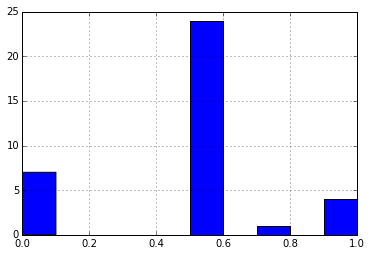

In [6]:
book_data.Position.hist()

In [7]:
agents = []
for i, row in book_data.iterrows():
    new_agent = BDMActor(row.Country, row.Capability, row.Position, 1)
    agents.append(new_agent)

model = Real_Negotiation_Model(agents)

(0, 1)

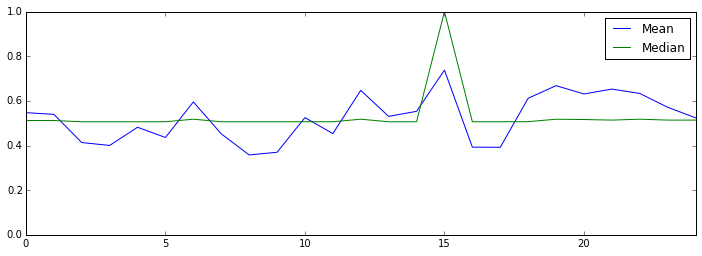

In [8]:
p_shock = 1

for i in range(25):
    model.step()
    for agent in model.agents:
        if random.random() < p_shock:
            agent.salience = random.random()

df = model.datacollector.get_model_vars_dataframe()
fig, ax = plt.subplots(figsize=(12,4))
df.plot(ax=ax)
ax.set_ylim(0, 1)

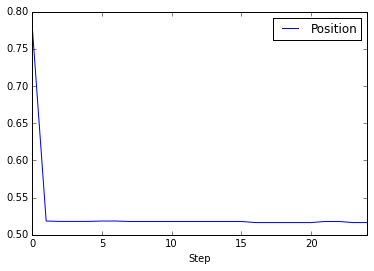

In [11]:
model.datacollector.get_agent_vars_dataframe().xs("Canada", level="AgentID").plot()

In [12]:
model.agent_names["USA"]

USA                 	Position: 0.95	Capability: 29.96	Salience: 0.09

In [13]:
usa = model.agent_names["USA"]
usa.decision_model.action_log

['USA conflict with Argentina',
 'USA conflict with Argentina',
 'USA conflict with Syria',
 'USA conflict with Philippines',
 'USA conflict with Philippines',
 'USA conflict with Saudi Arabia',
 'USA conflict with India',
 'USA conflict with Italy',
 'USA conflict with Belgium',
 'USA conflict with India',
 'USA conflict with Thailand',
 'USA conflict with Canada',
 'USA conflict with England',
 'USA conflict with Netherlands',
 'USA conflict with Australia',
 'USA conflict with Greece',
 'USA conflict with Saudi Arabia',
 'USA conflict with Sweden',
 'USA conflict with Norway',
 'USA conflict with Syria',
 'USA conflict with Denmark',
 'USA conflict with Turkey',
 'USA conflict with Australia',
 'USA conflict with Iraq']

## Original Data Batch Run

In [12]:
agents = []
for i, row in book_data.iterrows():
    new_agent = BDMActor(row.Country, row.Capability, row.Position, 1)
    new_agent.decision_model.Q = 0.5
    new_agent.decision_model.T = 0.5
    #new_agent.decision_model.T = 1
    agents.append(new_agent)

In [13]:
all_models = []
for i in range(10):
    model = Real_Negotiation_Model(copy.deepcopy(agents))
    for _ in range(25):
        for agent in model.agents:
            agent.salience = random.random()
        model.step()
    all_models.append(model)
    if i % 1 == 0:
        print(i)

0
1
2
3
4
5
6
7
8
9


In [18]:
import pickle

In [24]:
all_model_out = [Model_Output(m) for m in all_models]

In [26]:
with open("Model_Dump.pickle", "wb") as f:
    pickle.dump(all_model_out, f)

In [28]:
with open("Model_Dump.pickle", "rb") as f:
    model_data = pickle.load(f)

In [31]:
all_dfs = []
for i, model in enumerate(model_data):
    df = model.model_vars
    df.reset_index(inplace=True)
    df.rename(columns={"index": "Step"}, inplace=True)
    df["Iteration"] = i
    all_dfs.append(df)

In [16]:
all_dfs = []
for i, model in enumerate(all_models):
    df = model.datacollector.get_model_vars_dataframe()
    df.reset_index(inplace=True)
    df.rename(columns={"index": "Step"}, inplace=True)
    df["Iteration"] = i
    all_dfs.append(df)

In [32]:
results = pd.concat(all_dfs)

In [33]:
results.rename(columns={"index": "Step"}, inplace=True)

In [34]:
results.head()

,Step,Mean,Median,Iteration
0,0,0.513046,0.5065,0
1,1,0.598795,0.5160,0
2,2,0.556596,0.5140,0
3,3,0.511794,0.5065,0
4,4,0.711166,1.0000,0


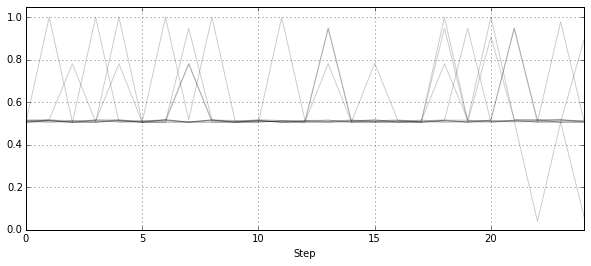

In [35]:
fig, ax = plt.subplots(figsize=(10, 4))
for i, group in results.groupby("Iteration"):
    group.plot(x="Step", y="Median", color='k', alpha=0.2, ax=ax, legend=False)

ax.set_ylim(0, 1.05)
ax.grid(True)

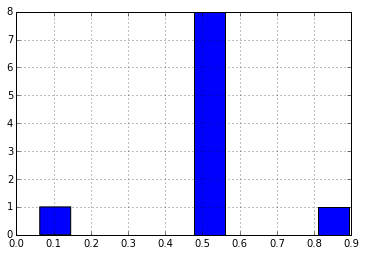

In [36]:
results[results.Step==24]["Median"].hist()

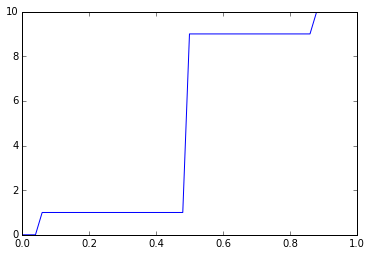

In [37]:
values, base = np.histogram(results[results.Step==24]["Median"], bins=np.linspace(0,1,51))
cdf = np.cumsum(values)
plt.plot(base[:-1], cdf)

In [23]:
m = all_models[7]

In [25]:
m.datacollector.agent_vars

{}

In [24]:
m.datacollector.get_agent_vars_dataframe()

ValueError: Length of new names must be 1, got 2

### Count conflict dyads

In [38]:
conflict_dyads = defaultdict(set)

#for i, model in enumerate(all_models):
for i, model in enumerate(model_data):
    for event in model.log.get_events(action="Attack"):
        source = event.source
        target = event.target
        if (target, source) in conflict_dyads:
            dyad = (target, source)
        else:
            dyad = (source, target)
        conflict_dyads[dyad].add(i)

In [39]:
conflict_count = Counter({k: len(v) for k, v in conflict_dyads.items()})

In [40]:
conflict_count.most_common()

[(('England', 'Iraq'), 10),
 (('Egypt', 'England'), 8),
 (('Argentina', 'USA'), 8),
 (('Belgium', 'Iran'), 8),
 (('Czechoslovakia', 'USSR'), 6),
 (('Belgium', 'Netherlands'), 6),
 (('Belgium', 'France'), 5),
 (('Argentina', 'Canada'), 5),
 (('Romania', 'USSR'), 4),
 (('USSR', 'Yugoslavia'), 4),
 (('Argentina', 'Mexico'), 4),
 (('Brazil', 'Canada'), 4),
 (('Hungary', 'Poland'), 4),
 (('Argentina', 'Brazil'), 4),
 (('Brazil', 'USA'), 3),
 (('Bulgaria', 'Yugoslavia'), 3),
 (('Bulgaria', 'Czechoslovakia'), 3),
 (('Czechoslovakia', 'Poland'), 3),
 (('Australia', 'Italy'), 3),
 (('Australia', 'China'), 3),
 (('Iran', 'Turkey'), 3),
 (('Australia', 'Denmark'), 3),
 (('Australia', 'Greece'), 3),
 (('Bulgaria', 'USSR'), 2),
 (('Norway', 'Sweden'), 2),
 (('Egypt', 'Netherlands'), 2),
 (('Czechoslovakia', 'Hungary'), 2),
 (('Australia', 'Belgium'), 2),
 (('Bulgaria', 'Romania'), 2),
 (('France', 'Iran'), 2),
 (('India', 'Italy'), 2),
 (('Italy', 'Sweden'), 2),
 (('Netherlands', 'Syria'), 2),
 (('

### Narrow it down to cases with a favorable US outcome

In [46]:
conflict_dyads = defaultdict(set)

for i, model in enumerate(model_data):
    if model.model_vars.Median[24] < 0.75:
        continue
    for event in model.log.get_events(action="Attack"):
        source = event.source
        target = event.target
        if (target, source) in conflict_dyads:
            dyad = (target, source)
        else:
            dyad = (source, target)
        conflict_dyads[dyad].add(i)

conflict_count = Counter({k: len(v) for k, v in conflict_dyads.items()})

In [47]:
conflict_count.most_common()

[(('Egypt', 'Turkey'), 1),
 (('Australia', 'Sweden'), 1),
 (('Poland', 'Yugoslavia'), 1),
 (('Egypt', 'England'), 1),
 (('Israel', 'Italy'), 1),
 (('Argentina', 'USA'), 1),
 (('USSR', 'Yugoslavia'), 1),
 (('Egypt', 'France'), 1),
 (('England', 'Iran'), 1),
 (('Czechoslovakia', 'USSR'), 1),
 (('Australia', 'India'), 1),
 (('Bulgaria', 'Romania'), 1),
 (('Egypt', 'Netherlands'), 1),
 (('Egypt', 'Iran'), 1),
 (('Belgium', 'Iran'), 1),
 (('Italy', 'Spain'), 1),
 (('France', 'Iraq'), 1),
 (('China', 'Israel'), 1),
 (('Hungary', 'Poland'), 1),
 (('Greece', 'South Africa'), 1),
 (('England', 'Iraq'), 1),
 (('Bulgaria', 'Poland'), 1),
 (('Australia', 'Belgium'), 1),
 (('Belgium', 'France'), 1),
 (('Argentina', 'Canada'), 1)]

In [55]:
usa = model.agent_vars.xs("USA", level="AgentID")
aus = model.agent_vars.xs("Australia", level="AgentID")

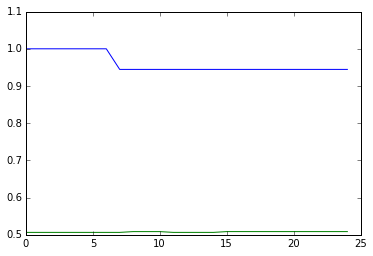

In [57]:
fig, ax = plt.subplots()
ax.plot(usa)
ax.plot(aus)

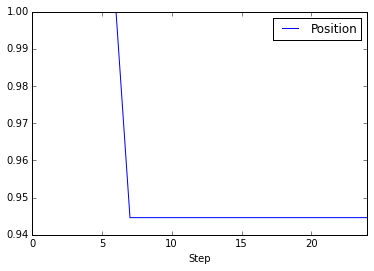

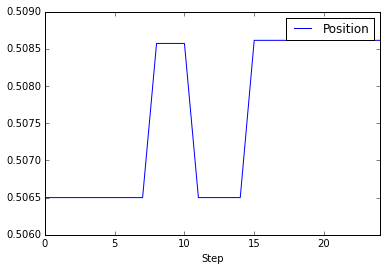

In [58]:
usa.plot()
aus.plot()